In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

In [3]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 700, 150

In [4]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Qbert', size=data_size+test_size)
print(len(seaquestdata["terminals"]))
print(np.unique(seaquestdata["terminals"], return_counts=True))

decompressing data...
Dataset loaded
864


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Dataset extracted with 978455 samples.
Information about the dataset:
Observation shape:  (978455, 4, 84, 84)
Action shape:  (978455,)
Reward shape:  (978455,)
Terminal shape:  (978455,)
Action space:  6
Observation space:  (84, 84)
Number of terminal states is... 849
Environment 'ALE/Qbert-ram-v5' initialized.
978455
(array([0, 1], dtype=uint8), array([977606,    849]))


In [5]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Qbert_123.pth", vocab_size=6, block_size=90, timesteps=3901, seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [6]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|██████████| 804000/804000 [01:31<00:00, 8746.61it/s] 
/Users/joanvelja/miniconda3/envs/mujoco_env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/27166 [00:00<?, ?it/s]/Users/joanvelja/miniconda3/envs/mujoco_env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 27166/27166 [05:51<00:00, 77.19it/s]


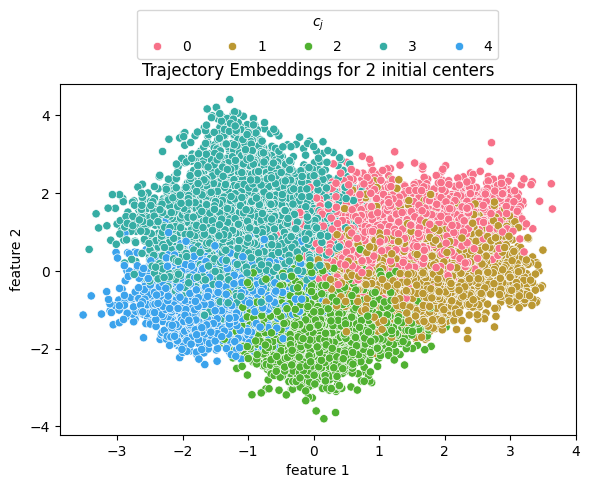

In [10]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 5, ccore=True, plot=True)

In [ ]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 6)
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=2000, n_steps_per_epoch=200, device=device)

In [ ]:
# Compute all possible permutations of clusters
print('#' * 100)
print("Compute all possible permutations of clusters")
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

In [ ]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

In [ ]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

In [ ]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)